In [1]:
import torch
# Config data

DATA_DIR = 'data/'
CHECKPOINT_DIR = 'checkpoints/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 24
lr = 0.01

In [3]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

# Dataset definition
class ImageNet_Challenge_Dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + '.jpg')
        image = read_image(img_path) / 255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Preprocess and DataLoader
preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip()
    ])
training_data = ImageNet_Challenge_Dataset(DATA_DIR + 'train.csv', DATA_DIR + 'train', transform=preprocess, target_transform=lambda x : x-1)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

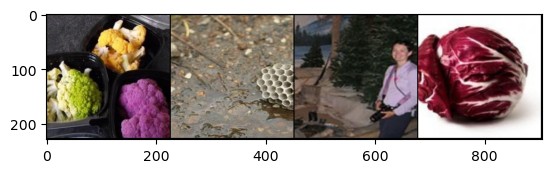

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Show example images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out)

In [5]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Define custom model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
import time
from tqdm import tqdm

# Train loop
losses = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        
        epoch_loss = running_loss / len(training_data)
        epoch_acc = running_corrects.double() / len(training_data)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        torch.save(model.state_dict(), CHECKPOINT_DIR + 'snapshot' + str(epoch) + '.pt')

        if epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

In [9]:
train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
            num_epochs=epochs)

Epoch 1/24
----------


100%|██████████| 63/63 [00:30<00:00,  2.03it/s]


Loss: 0.3652 Acc: 0.8882
Epoch 2/24
----------


100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Loss: 0.1229 Acc: 0.9560
Epoch 3/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.27it/s]


Loss: 0.1047 Acc: 0.9635
Epoch 4/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Loss: 0.0949 Acc: 0.9683
Epoch 5/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0711 Acc: 0.9748
Epoch 6/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Loss: 0.0814 Acc: 0.9700
Epoch 7/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0758 Acc: 0.9758
Epoch 8/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0606 Acc: 0.9790
Epoch 9/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Loss: 0.0581 Acc: 0.9808
Epoch 10/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


Loss: 0.0496 Acc: 0.9828
Epoch 11/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0504 Acc: 0.9840
Epoch 12/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Loss: 0.0477 Acc: 0.9855
Epoch 13/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0509 Acc: 0.9800
Epoch 14/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Loss: 0.0444 Acc: 0.9843
Epoch 15/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.28it/s]


Loss: 0.0432 Acc: 0.9843
Epoch 16/24
----------


100%|██████████| 63/63 [00:27<00:00,  2.32it/s]


Loss: 0.0434 Acc: 0.9858
Epoch 17/24
----------


100%|██████████| 63/63 [00:28<00:00,  2.25it/s]


Loss: 0.0549 Acc: 0.9800
Epoch 18/24
----------


100%|██████████| 63/63 [00:26<00:00,  2.35it/s]


Loss: 0.0498 Acc: 0.9840
Epoch 19/24
----------


100%|██████████| 63/63 [00:26<00:00,  2.34it/s]


Loss: 0.0400 Acc: 0.9868
Epoch 20/24
----------


100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


Loss: 0.0443 Acc: 0.9833
Epoch 21/24
----------


100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Loss: 0.0387 Acc: 0.9865
Epoch 22/24
----------


100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Loss: 0.0496 Acc: 0.9850
Epoch 23/24
----------


100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Loss: 0.0420 Acc: 0.9878
Epoch 24/24
----------


100%|██████████| 63/63 [00:25<00:00,  2.43it/s]

Loss: 0.0423 Acc: 0.9878

Training complete in 10m 58s
Best val Acc: 0.987750


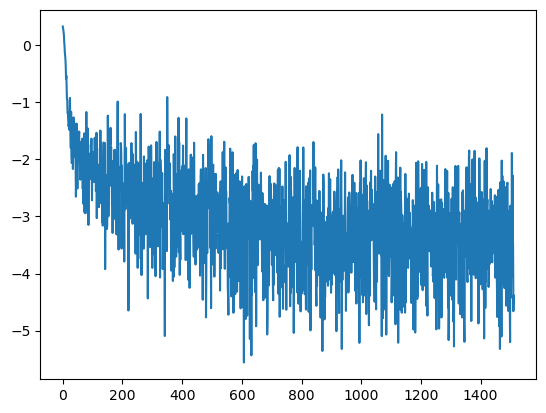

In [10]:
# Log Loss Plot, log function used for readability
plt.plot(range(len(losses)), np.log(losses))

In [25]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to('cuda:0')

checkpoint = torch.load('checkpoints/snapshot20.pt')
model.load_state_dict(checkpoint)
model.eval()

y_pred = []
y_true = []
for inputs, labels in train_dataloader:
    inputs = inputs.to('cuda:0')
    output = model(inputs)
    _, pred = torch.max(output, 1)
    y_pred.extend(pred.detach().cpu().numpy())
    y_true.extend(labels.detach().cpu().numpy())

<Axes: >

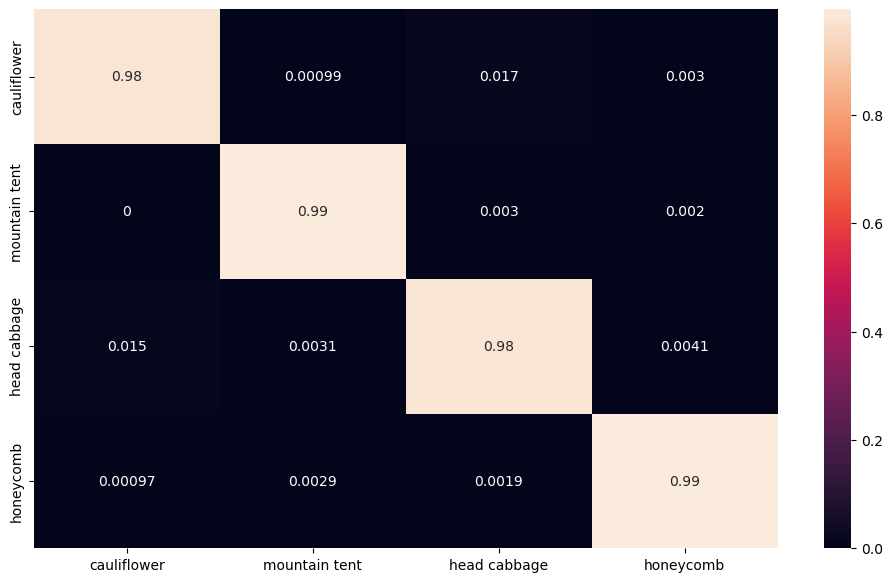

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

classes = ('cauliflower', 'mountain tent', 
           'head cabbage', 'honeycomb')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)